<a href="https://colab.research.google.com/github/BrendanGramp/UMDAOSC650/blob/main/autoencodermodified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras import layers

In [2]:
! wget https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc

--2024-04-04 16:41:22--  https://zenodo.org/records/10576726/files/current_SP3hourly_20110427.nc
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109400556 (104M) [application/octet-stream]
Saving to: ‘current_SP3hourly_20110427.nc’

current_SP3hourly_2 100%[===================>] 104.33M  18.2MB/s    in 7.0s    

2024-04-04 16:41:30 (14.9 MB/s) - ‘current_SP3hourly_20110427.nc’ saved [109400556/109400556]



In [3]:
ds = xr.open_dataset('current_SP3hourly_20110427.nc')

In [6]:
ds

<xarray.Dataset>
Dimensions:      (starttime: 2224, y: 32, x: 32)
Coordinates:
  * starttime    (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime      (starttime) float64 ...
    x_speed      (starttime) int64 ...
    y_speed      (starttime) int64 ...
Dimensions without coordinates: y, x
Data variables:
    uh25_grid    (starttime, y, x) float32 ...
    uh03_grid    (starttime, y, x) float32 ...
    ctt_grid     (starttime, y, x) float32 30.85 30.28 29.92 ... 6.861 6.969
    dbz_grid     (starttime, y, x) float32 ...
    mask         (starttime, y, x) int64 ...
    row_indices  (starttime, y, x) int64 ...
    col_indices  (starttime, y, x) int64 ...
    lats         (starttime, y, x) float32 ...
    lons         (starttime, y, x) float32 ...

## ANN Autoencoder

We will be training an autoencoder to perform the task of anomaly detection. For anomaly detection, we would note instances where reconstruction error for an image is higher, indicating that the sample was likely not similar to those in the training set distribution.

We will again use the previous data, but this time we will focus on reconstructing one input variable (feature).

In [5]:
ds['ctt_grid']

<xarray.DataArray 'ctt_grid' (starttime: 2224, y: 32, x: 32)>
array([[[30.846277, 30.279108, ..., 24.160944, 24.194544],
        [30.6896  , 30.205988, ..., 24.138666, 24.156153],
        ...,
        [30.277369, 30.2774  , ..., 26.490808, 26.25442 ],
        [30.505335, 30.508722, ..., 26.57281 , 26.230433]],

       [[25.258142, 25.295069, ..., 24.994104, 25.126917],
        [25.225428, 25.246546, ..., 24.939692, 25.09524 ],
        ...,
        [26.568964, 26.706263, ..., 26.439295, 26.521112],
        [26.157099, 26.472956, ..., 26.13833 , 26.378107]],

       ...,

       [[ 6.15835 ,  6.025629, ...,  9.892878, 10.899347],
        [ 6.217981,  6.145288, ...,  9.261835, 10.487543],
        ...,
        [ 5.472223,  5.668146, ..., 13.922358, 14.290552],
        [ 5.576868,  5.710046, ..., 13.969812, 14.191675]],

       [[ 9.979548,  9.917505, ...,  6.802606,  6.493005],
        [ 9.948603,  9.846491, ...,  6.554163,  6.430017],
        ...,
        [11.729609, 11.568995, ...,  6.786005,  6.865045],
        [11.844446, 11.534296, ...,  6.860742,  6.969079]]], dtype=float32)
Coordinates:
  * starttime  (starttime) float64 9.264e+04 9.264e+04 ... 9.266e+04 9.266e+04
    endtime    (starttime) float64 ...
    x_speed    (starttime) int64 ...
    y_speed    (starttime) int64 ...
Dimensions without coordinates: y, x

In [4]:
# reshape data to be samples, features
features_data = ds['ctt_grid'].stack(new_dim=(["y", "x"])).values
print(features_data.shape)

(2224, 1024)


In [7]:
features_data

array([[30.846277 , 30.279108 , 29.919764 , ..., 26.711267 , 26.57281  ,
        26.230433 ],
       [25.258142 , 25.295069 , 25.32879  , ..., 26.084314 , 26.13833  ,
        26.378107 ],
       [25.233667 , 25.231287 , 25.23791  , ..., 26.249506 , 26.371729 ,
        26.55047  ],
       ...,
       [22.516962 , 22.837183 , 23.074884 , ..., 25.021357 , 24.635523 ,
        24.421412 ],
       [ 6.1583495,  6.0256286,  5.8575683, ..., 13.852137 , 13.969812 ,
        14.191675 ],
       [ 9.9795475,  9.917505 ,  9.844233 , ...,  6.4862304,  6.860742 ,
         6.9690795]], dtype=float32)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    features_data,
    features_data,
    test_size=0.3,
    shuffle=False,
    random_state=42)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train) # input
X_test = scaler.transform(X_test) # input
y_train = scaler.transform(y_train) # label
y_test = scaler.transform(y_test) # label

In [12]:
scaler.mean_.shape

(1024,)

In [13]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1556, 1024) (668, 1024) (1556, 1024) (668, 1024)


In [14]:
# create fully connected autoencoder
model = keras.Sequential()

# input
model.add(keras.Input(shape=(1024))) # features

# encoder
# hidden layers
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(8, activation="relu"))

# desired dimensions

model.add(layers.Dense(2, activation="relu"))

# decoder

model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dense(32, activation="relu"))

# Finally, we add last layer
model.add(layers.Dense(1024, activation='linear')) # back to the original shape

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                32800     
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 2)                 18        
                                                                 
 dense_3 (Dense)             (None, 8)                 24        
                                                                 
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dense_5 (Dense)             (None, 1024)              33792     
                                                                 
Total params: 67186 (262.45 KB)
Trainable params: 67186 

In [15]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

BATCH_SIZE = 32
EPOCHS = 10

In [16]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
44/44 [==============================] - 2s 9ms/step - loss: 0.5251 - mean_squared_error: 0.5251 - root_mean_squared_error: 0.7247 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 2/10
44/44 [==============================] - 0s 4ms/step - loss: 0.0589 - mean_squared_error: 0.0589 - root_mean_squared_error: 0.2427 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_root_mean_squared_error: 0.1736
Epoch 3/10
44/44 [==============================] - 0s 5ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - root_mean_squared_error: 0.2392 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_root_mean_squared_error: 0.1872
Epoch 4/10
44/44 [==============================] - 0s 5ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - root_mean_squared_error: 0.2384 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_root_mean_squared_error: 0.1744
Epoch 5/10
44/44 [==============================] - 0s 4ms/step - loss: 

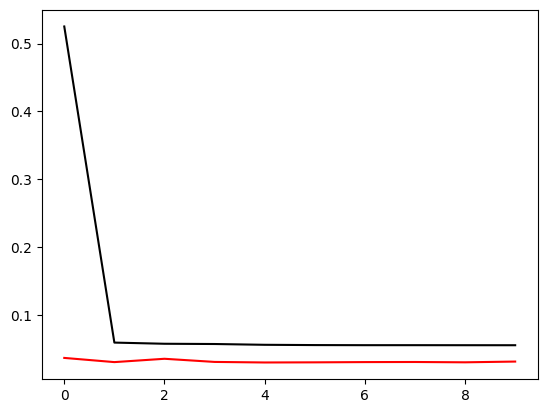

In [17]:
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

In [18]:
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 4ms/step


In [19]:
y_pred.shape

(668, 1024)

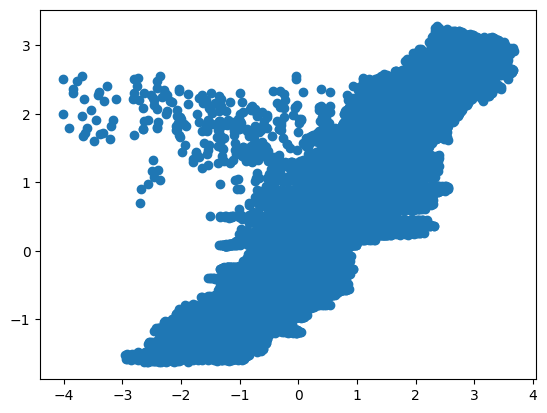

In [20]:
plt.scatter(y_test, y_pred)

In [21]:
mse_score = keras.metrics.MeanSquaredError(name='mean_squared_error')

In [22]:
mse_score.update_state(y_test, y_pred)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=668.0>

In [26]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.08305821

In [30]:
import keras as ks
#ks.backend.function([model.layers[0].input,
#model.layers[1].input,
#model.layers[2].input], [model.layers[2].output])

In [ ]:
#get_bottleneck = ks.backend.function

In [31]:
# saving model
model.save('autoencodersample.keras')

In [32]:
model2 = ks.models.load_model('autoencodersample.keras')

In [33]:
ypred2 = model2.predict(X_test)

21/21 [==============================] - 0s 4ms/step


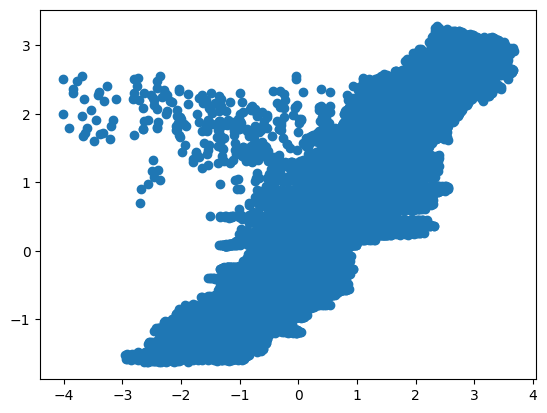

In [34]:
plt.scatter(y_test, ypred2)
plt.show()

## CNN Autoencoder

In [35]:
def z_score(da):
    """
    Compute z-score for training data.
    Normalizing data for ML model training.
    Args:
        da (array): Array of training variable.
    """
    return (da - np.mean(da)) / np.std(da)

def z_score_testing(da, testdata):
    """
    Compute z-score for testing data.
    Args:
        da (array): Array of training variable.
    """
    return (testdata - np.mean(da)) / np.std(da)

In [36]:
# reshape data to be samples, features
features_data = ds['ctt_grid'].values
print(features_data.shape)

(2224, 32, 32)


In [37]:
X_train, X_test, y_train, y_test = features_data[:1800], features_data[1800:], features_data[:1800], features_data[1800:]

In [38]:
X_test = z_score_testing(X_train, X_test) # input
y_test = z_score_testing(y_train, y_test) # label

X_train = z_score(X_train) # input
y_train = z_score(y_train) # label

In [39]:
# check shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1800, 32, 32) (424, 32, 32) (1800, 32, 32) (424, 32, 32)


In [40]:
model = keras.Sequential()

# input
model.add(keras.Input(shape=(32, 32, 1)))  # 32x32 images

# encoder
# hidden layers
model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.MaxPooling2D(2))

# decoder
model.add(layers.Conv2D(4, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(8, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

model.add(layers.Conv2D(16, 3, strides=1, padding="same", activation="relu"))
model.add(layers.UpSampling2D(2))

# Finally, we add last layer
model.add(layers.Conv2D(1, (3, 3), activation='linear', padding='same'))

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 4)           292       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 4)          

In [41]:
METRICS = [
    keras.metrics.MeanSquaredError(name='mean_squared_error'),
    keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=METRICS
)

BATCH_SIZE = 32
EPOCHS = 10

In [42]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/10
51/51 [==============================] - 4s 52ms/step - loss: 0.6713 - mean_squared_error: 0.6713 - root_mean_squared_error: 0.8193 - val_loss: 0.4738 - val_mean_squared_error: 0.4738 - val_root_mean_squared_error: 0.6883
Epoch 2/10
51/51 [==============================] - 2s 46ms/step - loss: 0.3062 - mean_squared_error: 0.3062 - root_mean_squared_error: 0.5533 - val_loss: 0.1020 - val_mean_squared_error: 0.1020 - val_root_mean_squared_error: 0.3194
Epoch 3/10
51/51 [==============================] - 2s 46ms/step - loss: 0.0833 - mean_squared_error: 0.0833 - root_mean_squared_error: 0.2885 - val_loss: 0.0836 - val_mean_squared_error: 0.0836 - val_root_mean_squared_error: 0.2892
Epoch 4/10
51/51 [==============================] - 4s 72ms/step - loss: 0.0543 - mean_squared_error: 0.0543 - root_mean_squared_error: 0.2331 - val_loss: 0.0516 - val_mean_squared_error: 0.0516 - val_root_mean_squared_error: 0.2271
Epoch 5/10
51/51 [==============================] - 2s 46ms/step - l

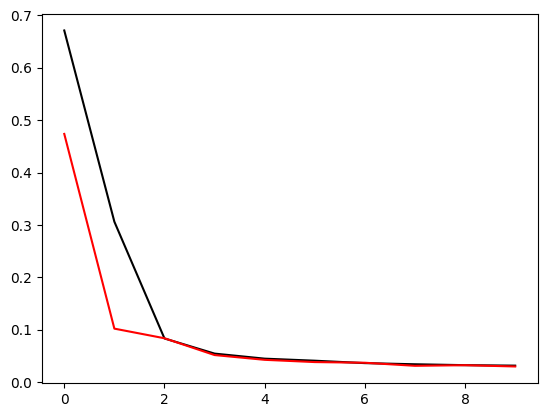

In [43]:
plt.plot(history.history["mean_squared_error"], c='k')
plt.plot(history.history["val_mean_squared_error"], c='r')
plt.show()

In [ ]:
# saving model
# evaluation mode
# evaluations

In [ ]:
# for predict anomalies/outliers in the training dataset
#prediction = model.predict(test_feats_standardized.values)

# for get the mean absolute error between actual and reconstruction/prediction
#prediction_loss = keras.losses.mae(prediction, test_feats_standardized.values)

## CNN Autoencoder Noise Removal

In [ ]:
def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 1.0)

In [ ]:
# Create a copy of the data with added noise
#noisy_train_data = noise(train_data)
#noisy_test_data = noise(test_data)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_feats_standardized.values, test_feats_standardized.values, batch_size=128)
print(results)

In [ ]:


# for check the prediction loss threshold for 2% of outliers
#loss_threshold = np.percentile(np.mean(prediction_loss, axis=(1,2)), 98)

#print(f'The prediction loss threshold for 2% of outliers is {loss_threshold:.2f}')
# for visualize the threshold
#plt.hist(np.mean(prediction_loss, axis=(1,2)), bins=30, alpha=0.8)
#plt.axvline(x=loss_threshold, color='orange')
#plt.show()